In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import tikzplotlib
from scipy.spatial import cKDTree
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score
from itertools import cycle, islice

In [2]:
def find_neighbors(data, point_index, eps):
    """
    Find neighbors of a data point in a dataset using Euclidean distance.
    
    Params:
    data -- array of data
    point_index -- index of central point which neighbors we want to find
    eps -- radius
    
    Return:
    list of lists - neighbors of point
    """
    tree = cKDTree(data)
    neighbors = tree.query_ball_point(data[point_index], eps)
    return data[neighbors].tolist()

In [3]:
def dbscan_fit(X, eps, minPts):
    """
    Fit DBSCAN iteration implementation.
    
    Params:
    X -- array of data
    eps -- radius of point
    minPts -- min count of point in circle
    
    Return:
    list of labels of cluster for each element in X
    """
    NV = X.tolist()
    Noise = list()
    clusters = list()
    while True:
        x = random.choice(NV)
        nbr = find_neighbors(np.array(NV), NV.index(x), eps)
        NV.remove(x)
        if len(nbr) < minPts:
            Noise.append(x)
        else:
            C = nbr.copy()
            for x_ in C:
                if x_ in Noise or x_ in NV:
                    nbr = find_neighbors(np.array(NV), NV.index(x_), eps)
                    if len(nbr) >= minPts:
                        C.extend(nbr)
                    else:
                        C.append(x_)
                    if x_ in Noise:
                        Noise.remove(x_)
                    if x_ in NV:
                        NV.remove(x_)
            [NV.remove(j) for j in C if j in NV]
            clusters.append(C)
        if not NV:
            break
    labels = []
    for x in X.tolist():
        if x in Noise:
            labels.append(-1)
        else:
            for i, cluster in enumerate(clusters):
                if x in cluster:
                    labels.append(i)
    return labels

In [4]:
def generate_data_sets(n_samples = 500, seed = 30, random_state = 170):
    """
    Generate 6 dataset of points.
    
    Params:
    n_samples -- size of dataset
    seed, random_state -- to make the same output for each run
    
    Return:
    datasets
    """
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
    blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)

    # Anisotropicly distributed data
    X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X_aniso = np.dot(X, transformation)
    aniso = (X_aniso, y)

    # blobs with varied variances
    varied = datasets.make_blobs(
        n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
    )

    rng = np.random.RandomState(seed)
    no_structure = rng.rand(n_samples, 2), None
    
    return noisy_circles, noisy_moons, blobs, aniso, varied, no_structure

In [5]:
def dbsacan_val_visualize(datasets, params=[[5,0.15],[5,0.18],[6,0.2],[6,0.25],[7,0.3],[7, 0.33]], tikz=True):
    """
    We validate algo and visualize result
    
    Params:
    datasets -- generated datasets
    params -- different params for algo
    tikz -- make .tex file of plot
    
    Return:
    ari for each dataset and each param
    """
    plt.figure(figsize=(20, 12))
    plt.subplots_adjust(
        left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
    )

    plot_num = 1
    
    ari_plot = [[0 for _ in range(len(params))] for _ in range(len(datasets) - 1)]

    for i_dataset, dataset in enumerate(datasets):
        X, y = dataset

        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        for i_params, (minPts, eps) in enumerate(params):
            y_pred = dbscan_fit(X, eps, minPts)
            
            ari = adjusted_rand_score(y, y_pred) if y is not None else ""
            if ari:
                ari_plot[i_dataset][i_params] = ari

            plt.subplot(6, 6, plot_num)
            if i_dataset == 0:
                plt.title(f"eps={eps}, minPts={minPts}", size=15)

            colors = np.array(
                list(
                    islice(
                        cycle(
                            [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                            ]
                        ),
                        int(max(y_pred) + 1),
                    )
                )
            )
            # add black color for outliers (if any)
            colors = np.append(colors, ["#000000"])
            plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        
            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plt.text(
                0.99,
                0.01,
                ("%.3f" % ari if ari else ""),
                transform=plt.gca().transAxes,
                size=15,
                horizontalalignment="right",
            )
            plot_num += 1
    if tikz:
        tikzplotlib.save(f"work.tex", flavor="context")
    plt.show()
    
    return ari_plot

In [9]:
def plot_ari(ari, names, params=[[5,0.15],[5,0.18],[6,0.2],[6,0.25],[7,0.3],[7, 0.33]], tikz=True):
    """
    We plot the accuracy (ARI) for each dataset
    
    Params:
    ari -- list of ari
    names -- name of dataset
    params -- eps-param
    tikz -- make .tex file of plot
    
    Return:
    None
    """
    x = [item[1] for item in params]

    fig, axs = plt.subplots(1, len(names), figsize=(15, 3))
    
    for i,ax in enumerate(axs):
        ax.plot(x, ari[i], c='cyan')
        ax.set_title(names[i])
        
        ax.set_xlabel('eps')
        ax.set_ylabel('ari')
        ax.grid()

    plt.tight_layout()
    if tikz:
        tikzplotlib.save(f"ari.tex", flavor="context")
    plt.show()

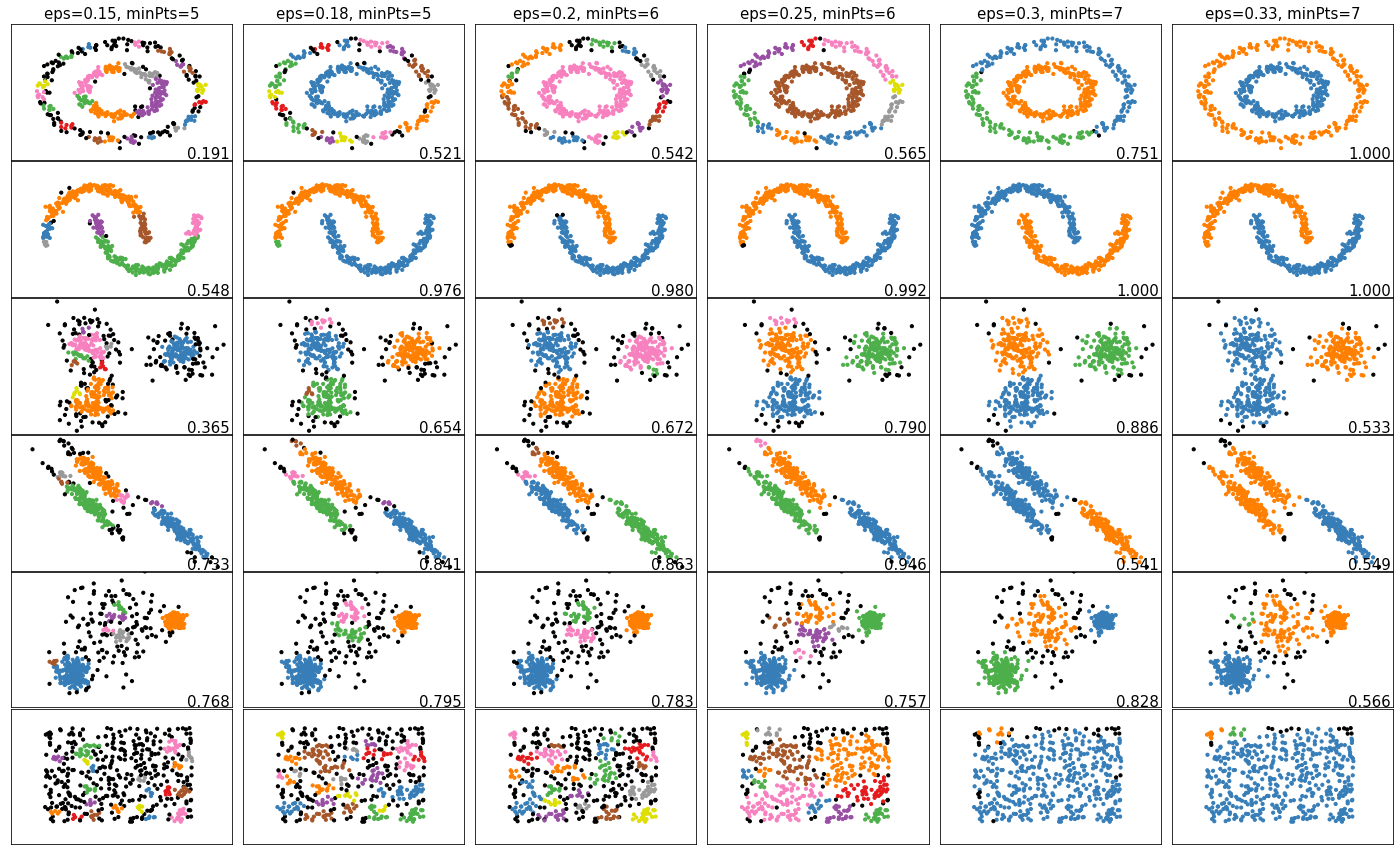

In [6]:
ari = dbsacan_val_visualize(datasets=generate_data_sets())

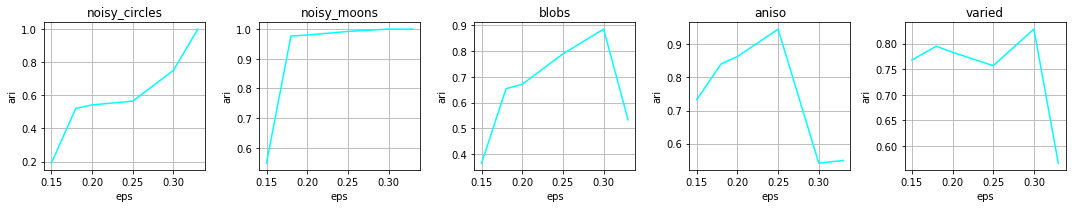

In [8]:
plot_ari(ari, ['noisy_circles', 'noisy_moons', 'blobs', 'aniso', 'varied'])